# Prepare time series of protein-protein interactions

We use the time series of protein concentrations over time to infer interaction activity 
- Input: chen xppaut output time series
- Output: link activity time series (normalised or not)

The script is structured as follows: 
1. Obtain time series of protein concentrations by simulating ODE model from Chen et al. (available at http://mpf.biol.vt.edu/research/budding_yeast_model/pp/getwinpp_current_model.php)
2. Create time series of interaction activity from node activity, save normalised and not normalised

The model comes from the study   
"Integrative Analysis of Cell Cycle Control in Budding Yeast" (2004)  
by K. Chen et al. in Molecular Biology of the Cell, Vol. 15, No. 8  
https://doi.org/10.1091/mbc.e03-11-0794

Note: this notebook is the only one that requires additional dependencies to simulate the .ode file
- xppaut: http://www.math.pitt.edu/~bard/xpp/xpp.html
- xppcall: https://github.com/iprokin/Py_XPPCALL (python wrapper for xppaut)

In [1]:
import copy

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sb
from networkx.drawing.nx_agraph import graphviz_layout

import phasik as pk

# from phasik.classes import TemporalData
# from phasik.drawing import plot_events, plot_phases, draw_graph, \
#     highlight_subgraphs, label_subplot_grid_with_shared_axes
# import phasik.temporal.TemporalData

from phasik.utils.xppcall import xpprun

sb.set_context("paper")

In [2]:
outdir = "../data/chen"  # directory to save data
fig_dir = "../images/chen/"  # directory to save figures

In [3]:
def tuple_name(name):
    return name.split("-")


def str_name(name):
    return "-".join(name)

## 1. Obtain time series of protein concentration by simulating Chen ODE model

In [4]:
xpp_filepath = "../data_raw/chen/bychen04_xpp.ode"  # simulation file

i_st = 100  # don't consider first transient cell cycle
i_end = 300  # look at 2 cell cycles

# simulate ode file
# temporal_data = TemporalData.from_ODEs(xpp_filepath, start_time=i_st, end_time=i_end, uppercase_vars=True)

npa, variables = xpprun(xpp_filepath, clean_after=True, xppname="/Applications/xppaut")

times = npa[i_st:i_end, 0]
npa = npa[i_st:i_end, :]

series = lambda name: npa[:, 1 + variables.index(name)]
variables = [var.upper() for var in variables]  # list of variables in the model
data = {var: series(var) for var in variables}  # dictionary with time series
temporal_data = pk.TemporalData.from_dict(data, times=times, true_times=times)

# data = temporal_data.to_dict() # dictionary with time series
# variables = list(data.keys()) # list of variables in the model
# times = temporal_data.true_times

In [5]:
xpp_filepath

'../data_raw/chen/bychen04_xpp.ode'

In [6]:
res = xpprun(xpp_filepath, clean_after=True)

In [7]:
res

In [8]:
print(f"The original Chen model contains {len(variables)} variables.")

The original Chen model contains 46 variables.


## 2. Explore data

### 2.1 Determine timing of special events

In the Chen model, there are four special variables that determine the timing of specific biological events.  
- The MASS variable increases throughout the cycle and drops at the end of it.  
- BUD=1 indicates bud emergence 
- ORI=1 indicates the start of DNA synthesis
- SPN=1 indicates completion of chromosome alignment on spindle

In [9]:
# determine special events

mass = data["MASS"]
bud = data["BUD"]
spn = data["SPN"]
ori = data["ORI"]

# cell cycle start and end
idx_mass = abs(np.diff(mass)) > 1  # abrupt change when cell divides
times_mass = times[:-1][idx_mass]

# bud emergence
idx_bud = (bud[1:] >= 1) * (bud[:-1] <= 1)  # where bud increases past 1
times_bud = times[:-1][idx_bud]

# start of DNA synthesis
idx_ori = (ori[1:] >= 1) * (ori[:-1] <= 1)
times_ori = times[:-1][idx_ori]

# chromosome alignment on spindle completed
idx_spn = (spn[1:] >= 1) * (spn[:-1] <= 1)
times_spn = times[:-1][idx_spn]

print(f"Start and end of cycle at {times_mass} min")

Start and end of cycle at [100. 201.] min


In [10]:
# define phases based on biological knowledge
phases = [(0, 35, "G1"), (35, 70, "S"), (70, 78, "G2"), (78, 100, "M")]

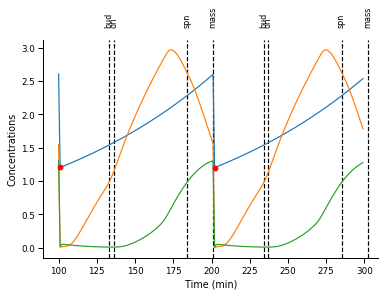

In [11]:
# plot special events

vars_ = ["MASS", "BUD", "SPN"]  # ORI not plotted for scaling reasons

fig, ax = plt.subplots()

temporal_data.plot_series(variables=vars_, ax=ax, labels_xvals=[165, 165, 160])

# plot start and end of cycle with red dot
temporal_data.plot_relative_optima("MASS", "minima", plot_var=False)

# plot vertical lines for special events
events_times = [times_bud[0], times_ori[0], times_spn[0], times_mass[1]]
events_labels = ["bud", "ori", "spn", "mass"]
events = [(time, name, "dashed") for time, name in zip(events_times, events_labels)]
pk.plot_events(events, ax=ax, text_y_pos=3.3, text_x_offset=0, period=101, n_periods=2)

ax.set_ylabel("Concentrations")
ax.set_xlabel("Time (min)")

sb.despine()

### 2.2 Dynamics of important proteins

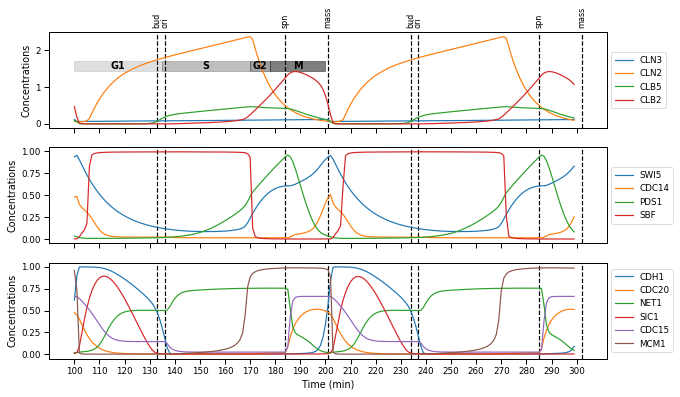

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 6))

var1 = ["CLN3", "CLN2", "CLB5", "CLB2"]
temporal_data.plot_series(variables=var1, ax=ax1, add_labels=False)

ax1.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(
    events,
    ax=ax1,
    text_y_pos=2.6,
    text_x_offset=0,
    period=101,
    n_periods=2,
    add_labels=True,
)
pk.plot_phases(phases, ax=ax1, y_pos=0.65, ymin=0.6, ymax=0.7, t_offset=100)
ax1.set_ylabel("Concentrations")

var2 = ["SWI5", "CDC14", "PDS1", "SBF"]  # +['ori']
temporal_data.plot_series(variables=var2, ax=ax2, add_labels=False)

ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(events, ax=ax2, period=101, n_periods=2, add_labels=False)
ax2.set_ylabel("Concentrations")

var3 = ["CDH1", "CDC20", "NET1", "SIC1", "CDC15", "MCM1"]
temporal_data.plot_series(variables=var3, ax=ax3, add_labels=False)

ax3.legend(loc="center left", bbox_to_anchor=(1, 0.5))
pk.plot_events(events, ax=ax3, period=101, n_periods=2, add_labels=False)
ax3.set_ylabel("Concentrations")

ax3.set_xlabel("Time (min)")
ax3.set_xticks(range(100, 305, 10))

# plt.savefig(f"protein_dynamics_full_chen.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"protein_dynamics_full_chen.pdf", dpi=250, bbox_inches="tight")

plt.show()

##  3. Extract time series of protein interactions

#### 3.1 Find proteins from Chen that are nodes in static PPI network

In [13]:
# extract links for which both nodes are present in the static PPI network
nodes_chen = sorted(list(data.keys()))
nodes_chen_raw = copy.deepcopy(nodes_chen)

# load static PPI network
static_PPI_network_filepath = "../data/kegg/static_PPI_network_KEGG.adjlist"
G = nx.read_adjlist(static_PPI_network_filepath)

edges_kegg = sorted([tuple(sorted(edge)) for edge in G.edges()])
nodes_kegg = sorted(list(G.nodes()))

In [14]:
# some variables in the Chen model represent protein complexes
# this dictionary links them to the actual interaction
# format:  {variable : corresponding interaction}
dic_links = {
    "C2": "CLB1-SIC1",
    "C5": "CLB6-SIC1",
    "F2": "CDC6-CLB1",
    "F5": "CDC6-CLB6",
    "CLB2": "CDC28-CLB1",
    "CLB5": "CDC28-CLB6",
    "CLN2": "CDC28-CLN1",
    "CLN3": "CDC28-CLN3",
    "SBF": "SWI4-SWI6",
    "MBF": "MBP1-SWI6",
}

split_sbf = ["SWI4", "SWI6", "MBP1"]

dic_links_rev = {v: k for k, v in dic_links.items()}

# change names for consistency with static PPI network
dic_transl = {"CLB2": "CLB1", "CLN2": "CLN1", "CLB5": "CLB6"}
dic_transl_rev = {v: k for k, v in dic_transl.items()}

# dic_split = {'SBF' : 'SWI4-SWI6'),
#             'MBF': ('MBP1-SWI6')}

# dic_split_rev = {v :k for k, v in dic_split.items() }


# change complex node into edge name
for old, new in dic_links.items():

    for i, node in enumerate(nodes_chen):
        if (old in node) and (len(node) <= 4):
            print(old, new)
            nodes_chen[i] = nodes_chen[i].replace(old, new)

# add mbf as link
nodes_chen.append(dic_links["MBF"])

# uniformise names
for old, new in dic_transl.items():

    for i, node in enumerate(nodes_chen):
        if old in node:
            print(old, "changed to ", new)
            nodes_chen[i] = nodes_chen[i].replace(old, new)
    # we need the list with simple nodes for later
    for i, node in enumerate(nodes_chen_raw):
        if old in node:
            print(old, "changed to ", new)
            nodes_chen_raw[i] = nodes_chen_raw[i].replace(old, new)

# add nodes that are only in complex form in Chen but exists alone in KEGG (e.g. CDC28)
nodes_chen_converted = np.unique(
    sum([tuple_name(var) for var in nodes_chen], [])
)  # flat list)

nodes_chen = sorted(set(nodes_chen))
edges_chen = [tuple(sorted(tuple_name(node))) for node in nodes_chen if "-" in node]

C2 CLB1-SIC1
C2 CLB1-SIC1
C5 CLB6-SIC1
C5 CLB6-SIC1
F2 CDC6-CLB1
F2 CDC6-CLB1
F5 CDC6-CLB6
F5 CDC6-CLB6
CLB2 CDC28-CLB1
CLB5 CDC28-CLB6
CLN2 CDC28-CLN1
CLN3 CDC28-CLN3
SBF SWI4-SWI6
CLB2 changed to  CLB1
CLB2 changed to  CLB1
CLB2 changed to  CLB1
CLN2 changed to  CLN1
CLB5 changed to  CLB6
CLB5 changed to  CLB6
CLB5 changed to  CLB6


In [15]:
# nodes common between KEGG and Chen

nodes_common = set(nodes_chen).intersection(nodes_kegg)
print(f"{len(nodes_common)} common nodes: ")
print(nodes_common)

14 common nodes: 
{'BUB2', 'CDC15', 'SIC1', 'CDC14', 'CDH1', 'CDC20', 'LTE1', 'TEM1', 'MCM1', 'ESP1', 'CDC6', 'SWI5', 'PDS1', 'NET1'}


In [16]:
# nodes common between KEGG and Chen

nodes_common = set(nodes_chen_converted).intersection(nodes_kegg)
print(f"{len(nodes_common)} common nodes (including complex protein nodes split): ")
print(nodes_common)

22 common nodes (including complex protein nodes split): 
{'SWI6', 'MBP1', 'CLB1', 'SWI4', 'SWI5', 'TEM1', 'CDC15', 'SIC1', 'CDH1', 'CDC20', 'CLN1', 'MCM1', 'ESP1', 'PDS1', 'CLN3', 'CDC14', 'LTE1', 'CLB6', 'CDC28', 'BUB2', 'CDC6', 'NET1'}


In [17]:
def is_a_complex(node):
    return (node in nodes_chen_raw) and not (node in nodes_chen)


def is_a_simple(node):
    return node in nodes_chen

#### 2.2 Find pairs of proteins in Chen that are an edge in static PPI network

In [18]:
# extract links: for each link static PPI network, if both nodes exist in Chen, extract temporal link

edges_common = {}

for edge in edges_kegg:
    e1, e2 = edge

    #     if edge==('CDC6', 'CLB6') :
    #         print(edge)

    if edge in edges_chen:  # special complex node in chen
        edges_common[edge] = "edge 1 chen node"

        if is_a_complex(e1) and is_a_simple(e2):
            edge_c = tuple(sorted(["CDC28", e2]))
            edges_common[edge_c] = "edge 1+1 special chen nodes"
        elif is_a_complex(e2) and is_a_simple(e1):
            edge_c = tuple(sorted(["CDC28", e1]))
            edges_common[edge_c] = "edge 1+1 special chen nodes"

    elif e1 in nodes_chen and e2 in nodes_chen:  # both nodes exist in chen
        edges_common[edge] = "edge 2 chen nodes"

    elif is_a_complex(e1) and is_a_simple(
        e2
    ):  # both nodes exist in chen but e1 is complex

        print("special", edge)
        edges_common[edge] = "edge 1+1 special chen nodes"
        edge_c = tuple(sorted(["CDC28", e2]))
        edges_common[edge_c] = "edge 1+1 special chen nodes"
        print("special", edge_c, "added extra")

    elif is_a_complex(e2) and is_a_simple(
        e1
    ):  # both nodes exist in chen but e1 is complex

        print("special", edge)
        edges_common[edge] = "edge 1+1 special chen nodes"
        edge_c = tuple(sorted(["CDC28", e1]))
        edges_common[edge_c] = "edge 1+1 special chen nodes"
        print("special", edge_c, "added extra")

    elif e1 in nodes_chen_converted and e2 in nodes_chen_converted:

        edges_common[edge] = "edge 1+1 special chen nodes"
        print("converted-----------------------", edge)
        # e.g. ('CLN1', 'SWI4') because comes from complex CLN1
        # and from SBF
        pass

    else:
        #         print('---unused', edge)
        pass

print()
print("-----------")
print("check we did not add edges that were not in kegg")
intersection = set(edges_common).difference(edges_kegg)
print(f"edges that were not in static PPI network: {intersection}")

for edge in intersection:
    del edges_common[edge]
    print(f"deleted {edge}")
# edges_common = list(set(edges_common).intersection(edges_kegg))
print(f"number of common edges: {len(edges_common)}")

special ('CDC20', 'CLB6')
special ('CDC20', 'CDC28') added extra
converted----------------------- ('CDC28', 'CDC6')
converted----------------------- ('CDC28', 'SIC1')
converted----------------------- ('CDC28', 'SWI5')
converted----------------------- ('CDC28', 'SWI6')
special ('CDH1', 'CLB1')
special ('CDC28', 'CDH1') added extra
special ('CLB1', 'SWI5')
special ('CDC28', 'SWI5') added extra
converted----------------------- ('CLB6', 'MBP1')
converted----------------------- ('CLB6', 'SWI6')
special ('CLN1', 'SIC1')
special ('CDC28', 'SIC1') added extra
converted----------------------- ('CLN1', 'SWI4')
converted----------------------- ('CLN1', 'SWI6')
special ('CLN3', 'MCM1')
special ('CDC28', 'MCM1') added extra
converted----------------------- ('CLN3', 'SWI6')

-----------
check we did not add edges that were not in kegg
edges that were not in static PPI network: {('CDC28', 'CDH1'), ('CDC28', 'MCM1'), ('CDC20', 'CDC28')}
deleted ('CDC28', 'CDH1')
deleted ('CDC28', 'MCM1')
deleted ('CDC

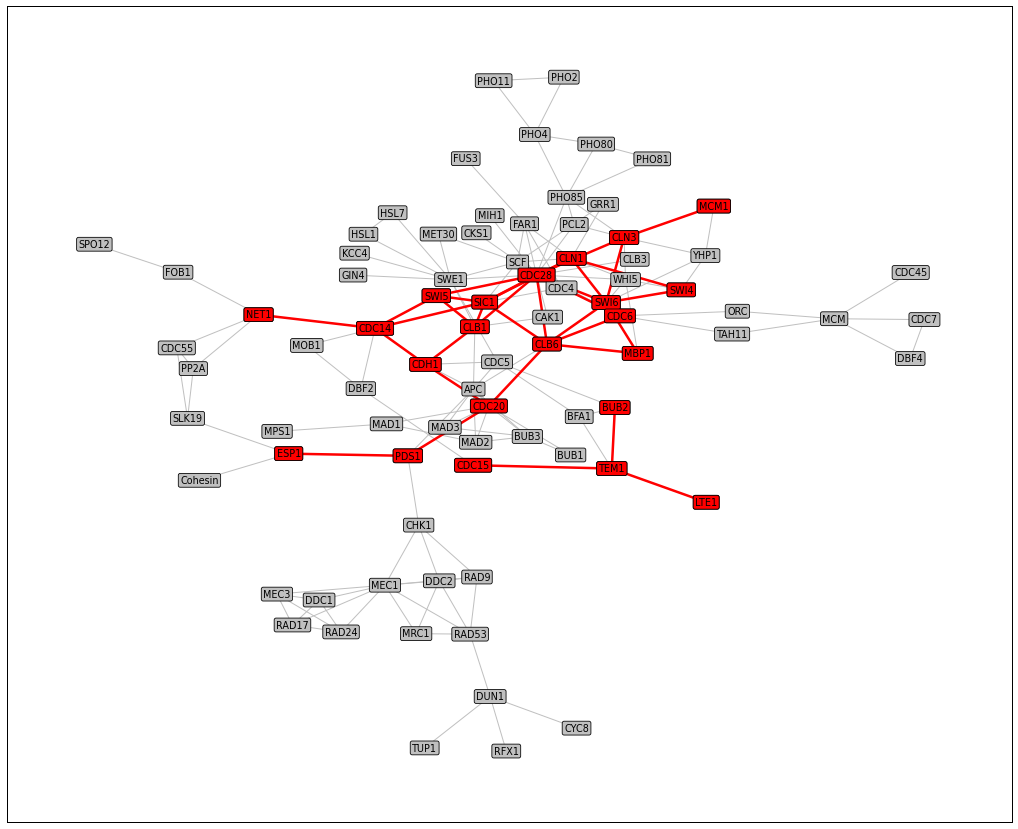

In [19]:
# plot static PPI network and highlight temporal edges and nodes
fig, ax = plt.subplots(figsize=(18, 15))

params = pk.standard_node_params("silver")
params_nodes_temporal = pk.standard_node_params("red")
params_edges_temporal = pk.standard_edge_params("red")
params_labels_temporal = pk.standard_label_params("red")

pk.draw_graph(G, ax=ax, color="silver")
pos = graphviz_layout(G, prog="neato")

# highlight temporal nodes and edges in red
nx.draw_networkx_edges(
    G,
    edgelist=list(edges_common.keys()),
    width=2.5,
    pos=pos,
    **params_edges_temporal,
)
nx.draw_networkx_nodes(G, nodelist=nodes_common, pos=pos, **params_nodes_temporal)
nx.draw_networkx_labels(
    G,
    labels={node: node for node in nodes_common},
    pos=pos,
    **params_labels_temporal,
)

# plt.savefig(f'{fig_dir}static_PPI_temporal_highlighted.png', dpi=300, bbox_inches='tight')
# plt.savefig(f'{fig_dir}static_PPI_temporal_highlighted.svg', dpi=300, bbox_inches='tight')

plt.show()

In [20]:
# save list of temporal nodes and temporal edges
np.save("nodes_common.npy", list(nodes_common))
np.save("edges_common.npy", list(edges_common.keys()))

#### 2.3 Generate times series of protein interactions from protein concentrations

In [21]:
links_activity_continuous = {}  # time series of edge activities

for edge, type_ in edges_common.items():

    e1, e2 = edge

    if type_ == "edge 2 chen nodes":  # activity = product of both concentrations

        links_activity_continuous[str_name(edge)] = data[e1] * data[e2]

    elif type_ == "edge 1 chen node":  # activity = concentration of complex node

        key = dic_links_rev[str_name(edge)]
        if key == "MBF":
            key = "SBF"
        links_activity_continuous[str_name(edge)] = data[key]

    elif (
        type_ == "edge 1+1 special chen nodes"
    ):  # activity = product of both concentrations

        if e1 == "CDC28" or e2 == "CDC28":
            #             print("passed", edge)
            if edge == ("CDC28", "CDC6"):
                links_activity_continuous[str_name(edge)] = data[
                    "F5"
                ]  # done by hand, can be improved
            else:
                pass  # will be added in another if branch
        else:

            # find right key
            if e1 not in data.keys():
                if e1 in split_sbf:
                    key1 = "SBF"
                else:
                    key1 = dic_transl_rev[e1]
            else:
                key1 = e1
            if e2 not in data.keys():
                if e2 in split_sbf:
                    key2 = "SBF"
                else:
                    key2 = dic_transl_rev[e2]
            else:
                key2 = e2

            links_activity_continuous[str_name(edge)] = data[key1] * data[key2]

            # add link with CDC28 (cannot be added otherwise because comes from complex node)
            if is_a_complex(e1) and is_a_simple(e2):
                edge_c = tuple(sorted(["CDC28", e2]))
                links_activity_continuous[str_name(edge_c)] = data[key1] * data[key2]

            elif is_a_complex(e2) and is_a_simple(e1):
                edge_c = tuple(sorted(["CDC28", e1]))
                links_activity_continuous[str_name(edge_c)] = data[key1] * data[key2]

            elif is_a_complex(e1) and e2 in split_sbf:
                edge_c = tuple(sorted(["CDC28", e2]))
                if edge_c in edges_common.keys():
                    links_activity_continuous[str_name(edge_c)] = (
                        data[key1] * data[key2]
                    )

            elif is_a_complex(e2) and e1 in split_sbf:
                edge_c = tuple(sorted(["CDC28", e1]))
                if edge_c in edges_common.keys():
                    links_activity_continuous[str_name(edge_c)] = (
                        data[key1] * data[key2]
                    )

            else:
                print("warning", edge)

In [22]:
# remove links that are not in static PPI network
for edge in list(links_activity_continuous.keys()):
    name = tuple(tuple_name(edge))
    if name not in list(edges_common.keys()):
        print("delete", name)
        del links_activity_continuous[edge]

delete ('CDC20', 'CDC28')
delete ('CDC28', 'CDH1')
delete ('CDC28', 'MCM1')


In [23]:
# make a TemporalData object for times series, to use convenient methods

edges_time_series = pk.TemporalData.from_dict(
    links_activity_continuous, times=times, true_times=times, i_tend=102
)
edges_time_series.to_df().head()

0         1         2         3         4         5    \
BUB2-TEM1   0.195567  0.184758  0.160733  0.139685  0.120566  0.102952   
CDC14-CDH1  0.299532  0.436299  0.395945  0.357749  0.334593  0.307924   
CDC14-NET1  0.008274  0.008589  0.009147  0.009360  0.009564  0.009844   
CDC14-SIC1  0.003361  0.009277  0.036108  0.089173  0.134154  0.164014   
CDC14-SWI5  0.453508  0.463213  0.358881  0.302718  0.263753  0.225892   

                 6         7         8         9    ...       92        93   \
BUB2-TEM1   0.086739  0.071972  0.058790  0.047386  ...  0.195567  0.195567   
CDC14-CDH1  0.273636  0.231979  0.186553  0.141945  ...  0.000716  0.000983   
CDC14-NET1  0.010194  0.010592  0.010963  0.011206  ...  0.012727  0.012655   
CDC14-SIC1  0.175902  0.169184  0.148579  0.120147  ...  0.000088  0.000106   
CDC14-SWI5  0.186806  0.147485  0.110546  0.078489  ...  0.051118  0.059186   

                 94        95        96        97        98        99   \
BUB2-TEM1   0.195567  0.195567  0.195567  0.195567  0.195567  0.195567   
CDC14-CDH1  0.001465  0.002455  0.004763  0.010812  0.026938  0.065585   
CDC14-NET1  0.012514  0.012307  0.011873  0.011361  0.010566  0.009810   
CDC14-SIC1  0.000133  0.000176  0.000247  0.000368  0.000565  0.000894   
CDC14-SWI5  0.071054  0.089535  0.118515  0.163410  0.225137  0.298934   

                 100       101  
BUB2-TEM1   0.195567  0.195567  
CDC14-CDH1  0.141933  0.265924  
CDC14-NET1  0.009029  0.008398  
CDC14-SIC1  0.001484  0.002847  
CDC14-SWI5  0.373878  0.440607  

[5 rows x 102 columns]

In [24]:
# normalise time series
edges_time_series_normed = edges_time_series.normalise()

In [25]:
# save time series
edges_time_series.save_to_csv(f"{outdir}/edge_time_series.csv")
edges_time_series_normed.save_to_csv(f"{outdir}/edge_time_series_normed.csv")

### 2.4 Visualise time series

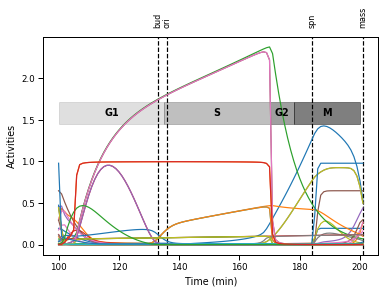

In [26]:
# plot time series of protein interactions

fig, ax = plt.subplots()

edges_time_series.plot_series(ax=ax, add_labels=False, norm=False)

pk.plot_events(events, ax=ax, text_y_pos=2.6, text_x_offset=0)
pk.plot_phases(phases, ax=ax, y_pos=0.65, ymin=0.6, ymax=0.7, t_offset=100)

ax.set_ylabel("Activities")
ax.set_xlabel("Time (min)")

# plt.savefig(f"{fig_dir}edge_times_series_compact.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{fig_dir}edge_times_series_compact.svg", dpi=250, bbox_inches="tight")

plt.show()

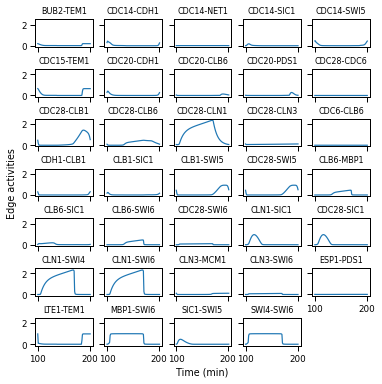

In [27]:
fig, axs = plt.subplots(7, 5, sharex=True, sharey=True, figsize=(6, 6))

i = 0
for edge in edges_time_series.to_df().index:

    ax = axs.flatten()[i]
    edges_time_series.plot_series([edge], ax=ax, add_labels=False, norm=False)

    ax.set_title(edge, fontsize="small")
    i += 1

# tidy up grid of axes
pk.label_subplot_grid_with_shared_axes(
    7,
    5,
    total_subplots=len(edges_time_series.to_df()),
    xlabel="",
    ylabel="",
    fig=fig,
    axes=axs,
)

axs[3, 0].set_ylabel("Edge activities")
axs[-1, 2].set_xlabel("Time (min)")

plt.subplots_adjust(hspace=0.8)

# plt.savefig(f"{fig_dir}edge_times_series.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{fig_dir}edge_times_series.svg", dpi=250, bbox_inches="tight")

plt.show()

### 2.5 Visualise normalised time series

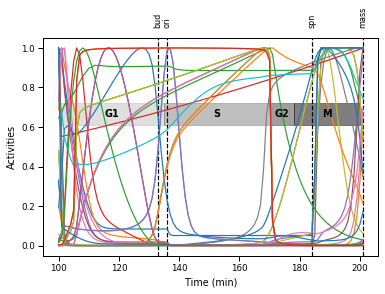

In [28]:
# plot time series of protein interactions

fig, ax = plt.subplots()

edges_time_series_normed.plot_series(ax=ax, add_labels=False)

pk.plot_events(events, ax=ax, text_y_pos=1.1, text_x_offset=0)
pk.plot_phases(phases, ax=ax, y_pos=0.65, ymin=0.6, ymax=0.7, t_offset=100)

ax.set_ylabel("Activities")
ax.set_xlabel("Time (min)")

# plt.savefig(f"{fig_dir}edge_times_series_compact_normed.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{fig_dir}edge_times_series_compact_normed.svg", dpi=250, bbox_inches="tight")

plt.show()

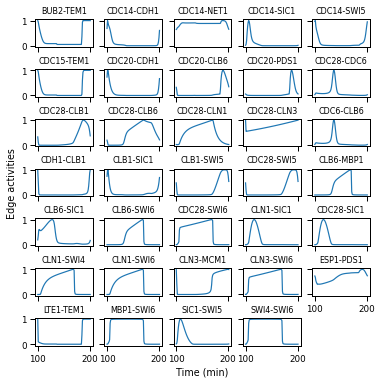

In [29]:
fig, axs = plt.subplots(7, 5, sharex=True, sharey=True, figsize=(6, 6))

i = 0
for edge in edges_time_series.to_df().index:

    ax = axs.flatten()[i]
    edges_time_series_normed.plot_series([edge], ax=ax, add_labels=False)

    ax.set_title(edge, fontsize="small")
    i += 1

# tidy up grid of axes
pk.label_subplot_grid_with_shared_axes(
    7,
    5,
    total_subplots=len(edges_time_series.to_df()),
    xlabel="",
    ylabel="",
    fig=fig,
    axes=axs,
)

axs[3, 0].set_ylabel("Edge activities")
axs[-1, 2].set_xlabel("Time (min)")

plt.subplots_adjust(hspace=0.8)

# plt.savefig(f"{fig_dir}edge_times_series_normed.png", dpi=250, bbox_inches="tight")
# plt.savefig(f"{fig_dir}edge_times_series_normed.svg", dpi=250, bbox_inches="tight")

plt.show()

## Save data for additional tests

### get all time series of nodes that are in the static PPI (even those representing complexes (edges))

In [30]:
nodes_complete = {}
for node in nodes_common:

    if node in dic_transl_rev.keys():
        key = dic_transl_rev[node]
    elif node == "CDC28":
        pass
    elif node in split_sbf:
        key = "SBF"
    else:
        key = node
    nodes_complete[key] = data[key]

print(nodes_complete.keys())

dict_keys(['SBF', 'CLB2', 'SWI5', 'TEM1', 'CDC15', 'SIC1', 'CDH1', 'CDC20', 'CLN2', 'MCM1', 'ESP1', 'PDS1', 'CLN3', 'CDC14', 'LTE1', 'CLB5', 'BUB2', 'CDC6', 'NET1'])


In [31]:
nodes_complete_series = pk.TemporalData.from_dict(
    nodes_complete, times=times, true_times=times, i_tend=102
)
nodes_complete_series_normalised = nodes_complete_series.normalise()
nodes_complete_series.to_df().head()

0         1         2         3         4         5         6    \
SBF    0.003372  0.003980  0.027667  0.068588  0.106024  0.177595  0.833380   
CLB2   0.473379  0.181724  0.018356  0.003434  0.001189  0.000530  0.000269   
SWI5   0.940334  0.955312  0.904989  0.845734  0.787867  0.733153  0.682076   
TEM1   0.977834  0.923788  0.803666  0.698427  0.602828  0.514761  0.433696   
CDC15  0.661778  0.658903  0.636755  0.608298  0.576794  0.542716  0.505998   

            7         8         9    ...       92        93        94   \
SBF    0.960781  0.977340  0.983640  ...  0.001261  0.001263  0.001273   
CLB2   0.000157  0.000103  0.000074  ...  1.349558  1.316987  1.281038   
SWI5   0.634670  0.590792  0.550232  ...  0.684969  0.702131  0.721583   
TEM1   0.359860  0.293948  0.236931  ...  0.977834  0.977834  0.977834   
CDC15  0.466651  0.425009  0.381888  ...  0.661661  0.661688  0.661696   

            95        96        97        98        99        100       101  
SBF    0.001291  0.001321  0.001371  0.001460  0.001633  0.002006  0.002963  
CLB2   1.241029  1.194560  1.136434  1.056702  0.939693  0.767458  0.532319  
SWI5   0.744380  0.771746  0.804321  0.840681  0.876877  0.908924  0.935296  
TEM1   0.977834  0.977834  0.977834  0.977834  0.977834  0.977834  0.977834  
CDC15  0.661701  0.661707  0.661716  0.661729  0.661744  0.661760  0.661775  

[5 rows x 102 columns]

In [32]:
# save time series
nodes_complete_series.save_to_csv(f"{outdir}/nodes_complete_series.csv")
nodes_complete_series_normalised.save_to_csv(
    f"{outdir}/nodes_complete_series_normalised.csv"
)

In [33]:
from itertools import combinations

edges_complete = {}

for node1, node2 in combinations(nodes_common, 2):
    edge_name = "-".join(sorted([node1, node2]))
    #     print(edge_name, node1, node2)
    try:

        if edge_name in dic_links_rev:
            key = dic_links_rev[edge_name]
            if key == "MBF":
                key = "SBF"
            edges_complete[edge_name] = data[key]

        elif "CDC28" in edge_name:
            pass  # links that don't exist such as CDC28-TEM1
        else:

            if node1 in split_sbf:
                #                 print('essss1')
                node1 = "SBF"
            if node2 in split_sbf:
                #                 print('essss2')
                node2 = "SBF"

            if node1 not in data.keys():
                key1 = dic_transl_rev[node1]
            else:
                key1 = node1
            if node2 not in data.keys():
                key2 = dic_transl_rev[node2]
            else:
                key2 = node2

            if key1 == "CDC28" or key2 == "CDC28":
                pass  # links that don't exist
            else:
                edges_complete[edge_name] = data[key1] * data[key2]

    except KeyError as e:
        raise (e)
        if e is "CDC28":
            pass
        else:
            print(edge_name, node1, node2)
            print("--------------------", e)

<>:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/w7/qwjxv8yd74s3mjqdnnykkqbc0000gp/T/ipykernel_91169/2405415568.py:43: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if e is 'CDC28' :


In [34]:
edges_complete_series = pk.TemporalData.from_dict(
    edges_complete, times=times, true_times=times, i_tend=102
)
edges_complete_series_normalised = edges_complete_series.normalise()
edges_complete_series.to_df()

0         1         2         3         4         5    \
MBP1-SWI6  0.003372  0.003980  0.027667  0.068588  0.106024  0.177595   
CLB1-SWI6  0.001596  0.000723  0.000508  0.000236  0.000126  0.000094   
SWI4-SWI6  0.003372  0.003980  0.027667  0.068588  0.106024  0.177595   
SWI5-SWI6  0.003171  0.003802  0.025038  0.058007  0.083533  0.130204   
SWI6-TEM1  0.003298  0.003677  0.022235  0.047903  0.063914  0.091419   
...             ...       ...       ...       ...       ...       ...   
CDC6-CLB6  0.000035  0.000068  0.000103  0.000103  0.000098  0.000093   
CLB6-NET1  0.001618  0.001003  0.000200  0.000024  0.000015  0.000012   
BUB2-CDC6  0.007378  0.018799  0.055143  0.097100  0.128719  0.153639   
BUB2-NET1  0.003431  0.003543  0.004613  0.005230  0.005714  0.006390   
CDC6-NET1  0.000633  0.001665  0.006359  0.012695  0.018388  0.024544   

                6         7         8         9    ...       92        93   \
MBP1-SWI6  0.833380  0.960781  0.977340  0.983640  ...  0.001261  0.001263   
CLB1-SWI6  0.000224  0.000151  0.000101  0.000073  ...  0.001701  0.001664   
SWI4-SWI6  0.833380  0.960781  0.977340  0.983640  ...  0.001261  0.001263   
SWI5-SWI6  0.568429  0.609779  0.577404  0.541230  ...  0.000863  0.000887   
SWI6-TEM1  0.361434  0.345747  0.287287  0.233055  ...  0.001233  0.001235   
...             ...       ...       ...       ...  ...       ...       ...   
CDC6-CLB6  0.000090  0.000088  0.000086  0.000084  ...  0.000004  0.000004   
CLB6-NET1  0.000017  0.000020  0.000025  0.000033  ...  0.046362  0.037454   
BUB2-CDC6  0.174516  0.192190  0.206758  0.218455  ...  0.001025  0.001092   
BUB2-NET1  0.007444  0.009116  0.011718  0.015712  ...  0.034109  0.030025   
CDC6-NET1  0.032477  0.043799  0.060568  0.085810  ...  0.000874  0.000819   

                94        95        96        97        98        99   \
MBP1-SWI6  0.001273  0.001291  0.001321  0.001371  0.001460  0.001633   
CLB1-SWI6  0.001631  0.001603  0.001578  0.001558  0.001543  0.001535   
SWI4-SWI6  0.001273  0.001291  0.001321  0.001371  0.001460  0.001633   
SWI5-SWI6  0.000919  0.000961  0.001020  0.001103  0.001228  0.001432   
SWI6-TEM1  0.001245  0.001263  0.001292  0.001341  0.001428  0.001597   
...             ...       ...       ...       ...       ...       ...   
CDC6-CLB6  0.000004  0.000005  0.000005  0.000007  0.000009  0.000012   
CLB6-NET1  0.029030  0.021353  0.014707  0.009661  0.006156  0.004011   
BUB2-CDC6  0.001175  0.001283  0.001433  0.001652  0.001990  0.002571   
BUB2-NET1  0.025418  0.020463  0.015464  0.011184  0.007891  0.005755   
CDC6-NET1  0.000746  0.000656  0.000554  0.000462  0.000393  0.000370   

                100       101  
MBP1-SWI6  0.002006  0.002963  
CLB1-SWI6  0.001540  0.001577  
SWI4-SWI6  0.002006  0.002963  
SWI5-SWI6  0.001823  0.002771  
SWI6-TEM1  0.001962  0.002897  
...             ...       ...  
CDC6-CLB6  0.000018  0.000031  
CLB6-NET1  0.002670  0.001784  
BUB2-CDC6  0.003689  0.006359  
BUB2-NET1  0.004390  0.003565  
CDC6-NET1  0.000405  0.000567  

[214 rows x 102 columns]

In [35]:
# save time series
edges_complete_series.save_to_csv(f"{outdir}/edges_complete_series.csv")
edges_complete_series_normalised.save_to_csv(
    f"{outdir}/edges_complete_series_normalised.csv"
)